In [5]:
using VMLS
using LinearAlgebra

## Chapter 18
# Nonlinear least squares
### 18.1 Nonlinear equations and least squares
### 18.2 Gauss–Newton algorithm
**Basic Gauss–Newton algorithm.** Let’s first implement the basic Gauss–Newton method (algorithm [18.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#algorithmctr.18.1) in VMLS) in Julia. In Julia, you can pass a function as an argument to another function, so we can pass `f` (the function) and also `Df` (the derivative or Jacobian matrix) to our Gauss–Newton algorithm.

```julia
function gauss_newton(f, Df, x1; kmax = 10)
    x = x1
    for k = 1:kmax
        x = x - Df(x) \ f(x)
    end
    return x
end
```

Here we simply run the algorithm for a fixed number of iterations `kmax`, specified
by an optional keyword argument with default value $10$. The code does not verify
whether the final `x` is actually a solution, and it will break down when $Df(x(k))$ has
linearly dependent columns. This very simple implementation is only for illustrative
purposes; the Levenberg–Marquardt algorithm described in the next section is
better in every way.

**Newton algorithm.** The Gauss–Newton algorithm reduces to the Newton algo-
rithm when the function maps $n$-vectors to $n$-vectors, so the function above is also
an implementation of the Newton method for solving nonlinear equations. The
only difference with the following function is the stopping condition. In Newton’s
method one terminates when $‖f(x^{(k)})‖$ is sufficiently small.
                        

In [7]:
function newton(f, Df, x1; kmax = 20, tol = 1e-6)
    x = x1
    fnorms = zeros(0,1)
    for k = 1:kmax
        fk = f(x)
        fnorms = [fnorms; norm(fk)]
        if norm(fk) < tol
            break
            end;
        x = x - Df(x) \ fk
    end
    return x, fnorms
end

newton (generic function with 1 method)

We added a second optional argument with the tolerance in the stopping condition on line $7$. The default value is $10−6$. We also added a second output argument `fnorms`, with the sequence $‖f(x^{(k)})‖$, so we can examine the convergence in the following examples.

**Newton algorithm for n = 1.** Our first example is a scalar nonlinear equation
$f(x) = 0$ with
$$
f(x) = \frac{e^{x} − e^{−x}}{e^{x} + e^{−x}}
$$
(VMLS figures [18.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.18.3) and [18.4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.18.4)). 

In [8]:
f(x) = (exp(x)-exp(-x)) / (exp(x)+exp(-x));
Df(x) = 4 / (exp(x) + exp(-x))^2;

We first try with $x^{(1)} = 0.95$.

In [9]:
x, fnorms = newton(f,Df,0.95);
f(x)

4.3451974324200454e-7

In [10]:
fnorms

5×1 Array{Float64,2}:
 0.7397830512740042   
 0.5941663642651942   
 0.23011124550034218  
 0.00867002864500575  
 4.3451974324200454e-7

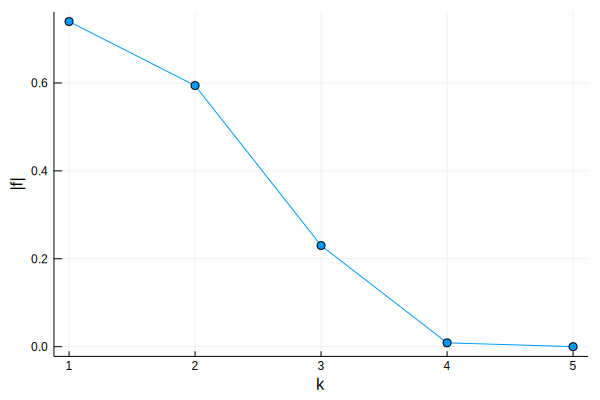

In [12]:
using Plots
plot(fnorms, shape=:circle, legend = false, xlabel = "k",ylabel = "|f|")

**Figure 18.1**<a ind="#fig1"></a> The first iterations in the Newton algorithm for solving $f(x) = 0$ for starting point $x(1) = 0.95$. 

The method converges very quickly, as can also be seen in figure [18.1](#fig1). However it does not converge for a slightly larger starting point $x(1) = 1.15$.

In [13]:
x, fnorms = newton(f,Df,1.15);
f(x)

NaN

In [14]:
fnorms[1:5]

5-element Array{Float64,1}:
   0.8177540779702877
   0.8664056534177534
   0.9735568532451108
   0.9999999999999906
 NaN                 

### 18.3 Levenberg–Marquardt algorithm 
The Gauss–Newton algorithm can fail if the derivative matrix does not have independent columns. It also does not guarantee that $‖f(x^{(k)})‖$ decreases in each iteration. Both of these shortcomings are addressed in the Levenberg–Marquardt algorithm. Below is a Julia implementation of algorithm [18.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#algorithmctr.18.3) in VMLS. This function is included in the `Vmls` package.

```julia
function levenberg_marquardt(f, Df, x1, lambda1; kmax=100, tol=1e-6)
    n = length(x1)
    x = x1
    lambda = lambda1
    objectives = zeros(0,1)
    residuals = zeros(0,1)
    for k = 1:kmax
        fk = f(x)
        Dfk = Df(x)
        objectives = [objectives; norm(fk)^2]
        residuals = [residuals; norm(2*Dfk'*fk)]
        if norm(2*Dfk'*fk) < tol
            break
            end;
        xt = x - [ Dfk; sqrt(lambda)*eye(n) ] \ [ fk; zeros(n) ]
        if norm(f(xt)) < norm(fk)
            lambda = 0.8*lambda
            x = xt
        else
            lambda = 2.0*lambda
        end
    end
    return x, Dict([ ("objectives", objectives),
            ("residuals", residuals)])
end
```

Line $12$ (`if norm(2*Dfk'*fk)`) is the second stopping criterion suggested on page [393](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.408) of VMLS, and checks whether the optimality condition ([18.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#equation.18.1.3)) is approximately satisfied. The default tolerance $10^{−6}$ can vary with the scale of the problem and the desired accuracy. Keep in mind that the optimality condition ([18.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#equation.18.1.3)) is a necessary condition and does not guarantee that the solution minimizes the nonlinear least squares objective $‖f(x)‖^2$. The code limits the number of iterations to `kmax`, after which it is assumed that the algorithm is failing to converge. 

The function returns a dictionary with information about the sequence of iterates, including the value of $‖f(x^{(k)}‖^2$ and $‖Df(x^{(k)})^T f(x^{(k)})‖$ at each iteration. 

Nonlinear equation. We apply the algorithm to the scalar function ([18.1](#fig1)) with the starting point $x(1) = 1.15$.
            
The result is shown in figure [18.2](#fig2).

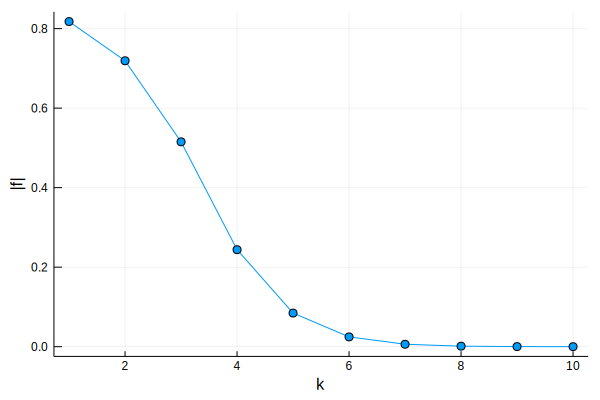

In [16]:
f(x) = (exp.(x) - exp.(-x)) / (exp.(x) + exp.(-x));
Df(x) = 4 ./ (exp.(x) + exp.(-x)).^2;
x, history = levenberg_marquardt(f, Df, [1.15], 1.0);
plot(sqrt.(history["objectives"][1:10]), shape = :circle,
    legend = false, xlabel = "k", ylabel = "|f|")

**Figure 18.<a ind="#fig2"></a>2** Values of $|f(x(k))|$ versus the iteration number $k$ for the Levenberg–Marquardt algorithm applied to 
$$
f(x) = \frac{(exp(x) − exp(−x))}{(exp(x)+exp(−x))}.
$$ 

The starting point is $x^{(1)} = 1.15$ and $λ^{(1)} = 1$.

Note that we defined $x^{(1)}$ as the array `[1.15]`, and use dot-operations in the definitions of `f` and `Df` to ensure that these functions work with vector arguments. This is important because Julia distinguishes between scalars and $1$-vectors. If we call the `levenberg_marquardt` function with a scalar argument `x1`, line $15$ will raise an `error`, because Julia does not accept subtractions of scalars and $1$-vectors.

**Equilibrium prices.** We solve a nonlinear equation $f(p) = 0$ with two variables, where 

$$
f(p) = exp(E^s log p+ s^{nom})− exp(E^d log p+ d^{nom}). 
$$

Here $exp$ and $log$ are interpreted as element-wise vector operations. The problem parameters are $s^{nom} = (2.2, 0.3), d^{nom} = (3.1, 2.2)$,

$$
E^s =
\begin{bmatrix}
0.5 & −0.3\\
−0.15 &  0.8
\end{bmatrix}
, E^d =
\begin{bmatrix}
−0.5 & 0.2\\
0 & −0.5
\end{bmatrix}.
$$

In [19]:
snom = [2.2, 0.3];
dnom = [3.1, 2.2];
Es = [0.5 -.3; -0.15 0.8];
Ed = [-0.5 0.2; -0.00 -0.5];
f(p) = exp.(Es * log.(p) + snom) - exp.(Ed * log.(p) + dnom);
function Df(p)
    S = exp.(Es * log.(p) + snom);
    D = exp.(Ed * log.(p) + dnom);
    return [ S[1]*Es[1,1]/p[1] S[1]*Es[1,2]/p[2]; 
        S[2]*Es[2,1]/p[1] S[2]*Es[2,2]/p[2] ] - [ D[1]*Ed[1,1]/p[1] D[1]*Ed[1,2]/p[2];
        D[2]*Ed[2,1]/p[1] D[2]*Ed[2,2]/p[2] ];
end;
p, history = levenberg_marquardt(f, Df, [3, 9], 1);
p

2-element Array{Float64,1}:
 5.644108533416072
 5.265754930531486

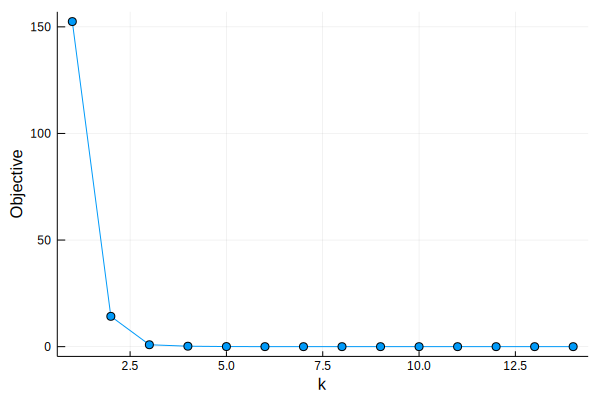

In [20]:
using Plots
plot(history["objectives"], shape = :circle, legend =false, xlabel = "k", ylabel = "Objective")

**Figure 18.<a ind="#fig"></a>3** Cost function $‖f(p^{(k)}‖^2$ versus iteration number $k$ for the example of equation ([18.2](#fig2).

**Location from range measurements.** The next example is the location from range measurements problem on page [396](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.415) in VMLS. The positions of the $m = 5$ points $a_i$ are given as rows in a $5 × 2$ matrix $A$. The measurements are given in a $5$-vector `rhos`. To simplify the code for the functions `f(x)` and `Df(x)` we add a function `dist(x)` that computes the vector of distances ($‖x− a_1‖, . . . , ‖x− a_m‖$).

The expression for the derivative is
\begin{equation}
Df(x) = 
\begin{bmatrix}
   \frac{x_1 - (a_{1})_{1}}{||x - a_1||} & \frac{x_2 - (a_{1})_{2}}{||x - a_1||} & \\
    \vdots & \vdots \\
    \frac{x_1 - (a_{m})_{1}}{||x - a_m||} & \frac{x_2 - (a_{m})_{2}}{||x - a_m||}
\end{bmatrix}
.
\end{equation}

This can be evaluated as the product of a diagonal matrix with diagonal entries
$\frac{1}{‖x− a_i‖}$ and the $5 × 2$ matrix with $i, j$ entry $(x − a_i)_j$ .

We run the `Levenberg–Marquardt` method for three starting points and $λ^{(1)} =
0.1$. The plot is shown in figure [18.4](#fig4).

In [21]:
# Five locations ai in a 5x2 matrix.
A = [ 1.8 2.5; 2.0 1.7; 1.5 1.5; 1.5 2.0; 2.5 1.5 ];
# Vector of measured distances to five locations.
rhos = [ 1.87288, 1.23950, 0.53672, 1.29273, 1.49353 ];
# dist(x) returns a 5-vector with the distances ||x-ai||.
dist(x) = sqrt.( (x[1] .- A[:,1]).^2 + (x[2] .- A[:,2]).^2 );
# f(x) returns the five residuals.
f(x) = dist(x) - rhos;
# Df(x) is the 5x2 derivative.
Df(x) = diagonal(1 ./ dist(x)) * [ (x[1] .- A[:,1]) (x[2] .- A[:,2]) ];
# Solve with starting point (1.8,3.5) and lambda = 0.1.
x1, history1 = levenberg_marquardt(f, Df, [1.8, 3.5], 0.1);
x1

2-element Array{Float64,1}:
 1.1824859803827907
 0.8242289367900364

In [22]:
# Starting point (3.0,1.5).
x2, history2 = levenberg_marquardt(f, Df, [3.0, 1.5], 0.1);
x2

2-element Array{Float64,1}:
 1.1824857942435818
 0.8242289466379732

In [23]:
# Starting point (2.2,3.5).
x3, history3 = levenberg_marquardt(f, Df, [2.2, 3.5], 0.1);
x3

2-element Array{Float64,1}:
 2.9852664103617954
 2.1215768036188956

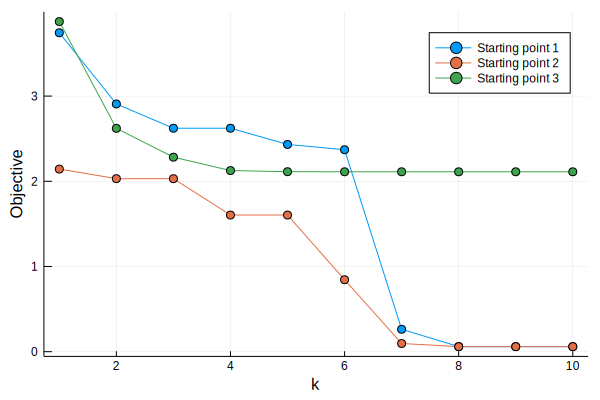

In [24]:
using Plots
plot(history1["objectives"][1:10], shape = :circle,
label = "Starting point 1")
plot!(history2["objectives"][1:10], shape = :circle,
label = "Starting point 2")
plot!(history3["objectives"][1:10], shape = :circle,
label = "Starting point 3")
plot!(xlabel = "k", ylabel = "Objective")

**Figure 18.<a ind="#fig4"></a>4** Cost function $‖f(x^{(k)})‖^2$ versus iteration number $k$ for the three starting points in the location from range measurements example.

### 18.4 Nonlinear model fitting
**Example.** We fit a model
$$
f̂(x; θ) = θ_1e^{θ{_2x}} cos(θ_3x+ θ_4)
$$
to $N = 60$ data points. We first generate the data.

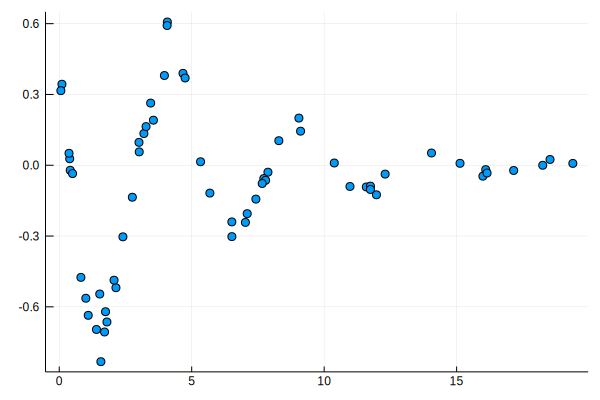

In [25]:
# Use these parameters to generate data.
theta_ex = [1, -0.2, 2*pi/5, pi/3];
# Choose 60 points x between 0 and 20.
M = 30;
xd = [5*rand(M); 5 .+ 15*rand(M)];
# Evaluate function at these points.
yd = theta_ex[1] * exp.(theta_ex[2]*xd) .* cos.(theta_ex[3] * xd .+ theta_ex[4])
# Create a random perturbation of yd.
N = length(xd);
yd = yd .* (1 .+ 0.2*randn(N)) .+ 0.015 * randn(N);
# Plot data points.
using Plots
scatter(xd, yd, legend=false)

The $60$ points are shown in figure [18.5](#fig5). We now run our Levenberg–Marquardt code with starting point $θ(1) = (1, 0, 1, 0)$ and $λ(1) = 1$. The fitted model is shown in figure [18.5](#fig5).

In [26]:
f(theta) = theta[1] * exp.(theta[2]*xd) .* cos.(theta[3] * xd .+ theta[4]) - yd;
Df(theta) = hcat(
    exp.(theta[2]*xd) .* cos.(theta[3] * xd .+ theta[4]),
    theta[1] * ( xd .* exp.(theta[2]*xd) .*
        cos.(theta[3] * xd .+ theta[4])),
    -theta[1] * ( exp.(theta[2]*xd) .* xd .*
        sin.(theta[3] * xd .+ theta[4])),
    -theta[1] * ( exp.(theta[2]*xd) .*
        sin.(theta[3] * xd .+ theta[4])) );
theta1 = [1, 0, 1, 0];
theta, history = levenberg_marquardt(f, Df, theta1, 1.0)
theta

4-element Array{Float64,1}:
  0.9323205639084152 
 -0.17994464859473006
  1.2430972267595168 
  1.0761484340773477 

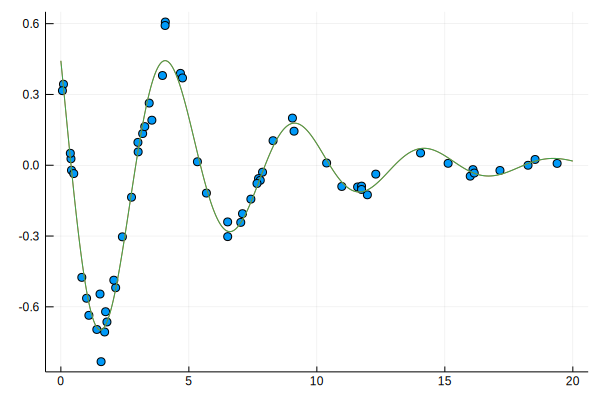

In [28]:
# Plot the fitted model.
x = linspace(0, 20, 500);
y=theta[1]*exp.(theta[2]*x) .* cos.(theta[3]*x .+ theta[4]);
plot!(x, y, legend = false)

**Figure 18.<a ind="#fig"></a>5** Least squares fit of a function $f̂(x; θ) = θ_1e^{θ_{2x}}cos(θ_3x+ θ_4)$ to
$N = 60$ points $(x^{(i)}, y^{(i)})$.

**Orthogonal distance regression.** In figure [18.14](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.18.14) of VMLS we use orthogonal distance regression to fit a cubic polynomial

$$
f̂(x; θ) = θ_1 + θ_2x+ θ_3x^2 + θ_4x^3
$$

to $N = 25$ data points.
We first read in the data and compute the standard least squares fit.

In [29]:
xd, yd = orth_dist_reg_data(); # 2 vectors of length N = 25
N = length(xd);
p = 4;
theta_ls = vandermonde(xd, p) \ yd;

The nonlinear least squares formulation on page 400 of VMLS has $p + N$ variables $\theta_1,...,\theta_p, u^{(1)}, ..., u^{(N)}$. We will store them in that order in the nonlinear least squares vector variable. The objective is to minimize the squared norm of the $2N$-vector

\begin{bmatrix}
   \hat{f}(u^{(1)}; \theta) - y^{(1)} \\
    \vdots \\
    \hat{f}(u^{(N)}; \theta) - y^{(N)} \\
    u^{(1)} - x^{(1)} \\
    \vdots \\
    u^{(N)} - x^{(N)}
\end{bmatrix}

In [31]:
function f(x)
    theta = x[1:p];
    u = x[p+1:end];
    f1 = vandermonde(u,p)*theta - yd
    f2 = u - xd
    return [f1; f2]
    end;

function Df(x)
    theta = x[1:p]
    u = x[p+1:end]
    D11 = vandermonde(u,p)
    D12 = diagonal(theta[2] .+ 2*theta[3]*u .+ 3*theta[4]*u.^2)
    D21 = zeros(N,p)
    D22 = eye(N)
    return [ D11 D12; D21 D22]
    end;

We now call `levenberg-marquardt` with these two functions. A natural choice for the initial point is to use the least squares solution for the variables $\theta$ and the data points $x^{(i)}$ for the variables $u^{(i)}$. We use $\lambda^{(1)} = 0.01$.

In [32]:
sol, hist = levenberg_marquardt(f, Df, [theta_ls; xd], 0.01);
theta_od = sol[1:p];

Figure [18.6](#fig6) shows the two fitted polynomials.

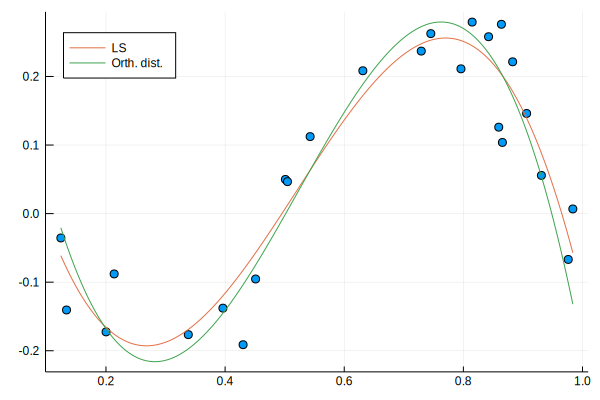

In [34]:
using Plots
scatter(xd,yd, label="", legend = :topleft);
x = linspace(minimum(xd), maximum(xd), 500);
y_ls = vandermonde(x, p) * theta_ls;
y_od = vandermonde(x, p) * theta_od;
plot!(x, y_ls, label = "LS")
plot!(x, y_od, label = "Orth. dist.")

**Figure 18.<a ind="#fig6"></a>6** Least squares and orthogonal distance regression fit of a cubic polynomial to $25$ data points.